In [1]:
import os
import csv
import sys
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

### Dataset info

Source: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Predicting daily bike rental ridership. Goal is to create Neural Network that will be able to tell how many bikes should be available on given day - based on historical data from January 1 2011 to December 31 2012.

### Loading files & extracting data

In [3]:
DATASET_DIRECTORY = "./bike-sharing/"

if os.path.isdir(DATASET_DIRECTORY):
    print("Bike-Sharing dataset found in directory '" + DATASET_DIRECTORY + "':")
    for file in os.listdir(DATASET_DIRECTORY):
        print("- "  + file)
else:
    print("Missing 'bike-sharing' data folder!")

Bike-Sharing dataset found in directory './bike-sharing/':
- day.csv
- hour.csv
- Readme.txt


In [4]:
rides_data = pd.read_csv(DATASET_DIRECTORY + "hour.csv")

In [5]:
print("Present fields:")
rides_data.head(10)

Present fields:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


Data presentation - first 30 days


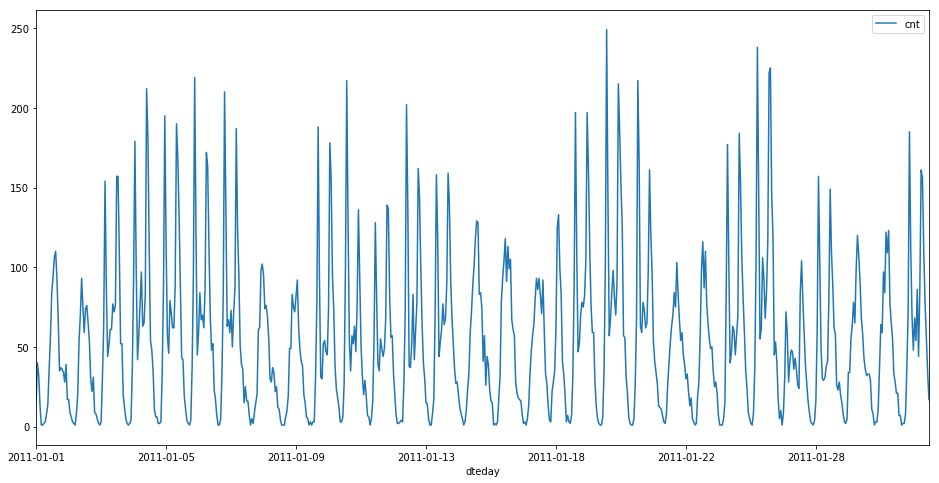

In [6]:
print("Data presentation - first 30 days")

first_30_days = rides_data.loc[rides_data["dteday"] < "2011-02-01"]
first_30_days.plot(figsize=(16, 8), x="dteday", y="cnt")

### Data Preprocessing

##### Create dummy values
For fields which are not numerical they have to be transformed info few binary fields. First of all Neural Network is multiplication of few aligned matrices with feedback that adjusts their values to reach desired output for given input. It is impossible to multiply strings so field like `"Weekday"` which takes values "Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday" has to be turned into seven separate fields (each value has it's own field) which can take binary value 0-1 (false or true).

In [7]:
print("Example of turning field to dummy: ")
weekday_dummy_example = pd.get_dummies(rides_data["weekday"], prefix="weekday", drop_first=False)
weekday_dummy_example.head(1)

Example of turning field to dummy: 


,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0,0,0,1


In [8]:
print("Before creating dummies: \n")
print(rides_data.columns)

Before creating dummies: 

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


In [9]:
def create_dummies(dataframe, fields):
    preprocesed_dataframe = dataframe.copy()
    for field in fields:
        dummies = pd.get_dummies(preprocesed_dataframe[field], prefix=field, drop_first=False)
        preprocesed_dataframe = pd.concat([preprocesed_dataframe, dummies], axis=1)
        
    return preprocesed_dataframe

In [10]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
rides_data_preprocessed = create_dummies(rides_data, dummy_fields)

In [11]:
print("After creating dummies: \n")
print(rides_data_preprocessed.columns)

After creating dummies: 

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8',
       'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6'],
      dtype='object')


##### Normalizing numerical values

In [12]:
def normalize_fields(dataframe, fields):
    normalized_dataframe = dataframe.copy()
    
    normalized_fields = {}
    for field in fields:
        mean, std = normalized_dataframe[field].mean(), normalized_dataframe[field].std()
        normalized_fields[field] = [mean, std]
        normalized_dataframe.loc[:, field] = (normalized_dataframe[field] - mean) / std
    
    return normalized_dataframe, normalized_fields

In [13]:
numerical_values = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

rides_data_preprocessed, normalization_info = normalize_fields(rides_data_preprocessed, numerical_values)

In [14]:
for field in numerical_values:
    print("- normalised values in field: " + field + ", mean: " 
          + str(rides_data_preprocessed.loc[:, field].mean()) + ", std: "
          + str(rides_data_preprocessed.loc[:, field].std()))

- normalised values in field: casual, mean: 3.27081068305e-17, std: 1.0
- normalised values in field: registered, mean: -5.80568896242e-17, std: 1.0
- normalised values in field: cnt, mean: -9.32181044671e-17, std: 1.0
- normalised values in field: temp, mean: 6.54162136611e-17, std: 1.0
- normalised values in field: hum, mean: -2.992791775e-16, std: 1.0
- normalised values in field: windspeed, mean: 1.3900945403e-16, std: 1.0


##### Split data - test, train, validation

Because it's historical/series data we will want Neural Network to learn from past data to predict well for incoming data. Therefore:

- December of 2012 will be used for test data
- October, November of 2012 will be used for validation data
- rest will be used for train data

In [15]:
test_data = rides_data_preprocessed.loc[rides_data_preprocessed["dteday"] >= "2012-12-01"]
train_data = rides_data_preprocessed.loc[rides_data_preprocessed["dteday"] < "2012-12-01"]

In [16]:
val_data = train_data.loc[train_data["dteday"] >= "2012-10-01"]
train_data = train_data.loc[train_data["dteday"] < "2012-10-01"]

In [17]:
print("Test data samples: " + str(test_data.shape[0]))
print("Validation data samples: " + str(val_data.shape[0]))
print("Train data samples: " + str(train_data.shape[0]))

Test data samples: 742
Validation data samples: 1426
Train data samples: 15211


##### Droping unused fields

In [18]:
def drop_fields(dataframe, fields):
    preprocessed_dataframe = dataframe.copy()
    for field in fields:
        del preprocessed_dataframe[field]
    
    return preprocessed_dataframe

In [19]:
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

test_data =  drop_fields(test_data, fields_to_drop)
val_data = drop_fields(val_data, fields_to_drop)
train_data = drop_fields(train_data, fields_to_drop)

##### Split data - features, targets

In [20]:
target_fields = ['cnt', 'casual', 'registered']

test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
val_features, val_targets = val_data.drop(target_fields, axis=1), val_data[target_fields]
train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

### Neural Network

In [21]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes_layer_1, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes_layer_1 = hidden_nodes_layer_1
        self.output_nodes = output_nodes
        self.lr = learning_rate
        
        # initialize weights and biases
        self.weights_i_to_h1 = np.random.uniform(
            (-1 / np.sqrt(self.input_nodes)), (1 / np.sqrt(self.input_nodes)), 
            (self.input_nodes, self.hidden_nodes_layer_1))
        self.bias_i_to_h1 = np.zeros(self.hidden_nodes_layer_1)

        self.weights_h1_to_o = np.random.uniform(
            (-1 / np.sqrt(self.hidden_nodes_layer_1)), (1 / np.sqrt(self.hidden_nodes_layer_1)),
            (self.hidden_nodes_layer_1, self.output_nodes))
        self.bias_h1_to_o = np.zeros(self.output_nodes)
    
    def activation_sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # won't be used - activated layer from forward pass will be used to speed up computation
    def activation_dSigmoid(self, x):
        return self.activation_sigmoid(x) * (1 - self.activation_sigmoid(x))

    def train(self, features, targets):
        n_records = features.shape[0]
        
        # placeholders for weights and biases change values
        delta_weights_i_h1 = np.zeros(self.weights_i_to_h1.shape)
        delta_weights_h1_o = np.zeros(self.weights_h1_to_o.shape)
        delta_bias_i_h1 = np.zeros(self.bias_i_to_h1.shape)
        delta_bias_h1_o = np.zeros(self.bias_h1_to_o.shape)
        
        for X, y in zip(features, targets):
            ### forward pass
            # input to hidden 1
            inputs_to_h1_layer = np.dot(X, self.weights_i_to_h1) + self.bias_i_to_h1
            inputs_to_h1_layer_activated = self.activation_sigmoid(inputs_to_h1_layer)
            
            # hidden 1 to output
            h1_to_output_layer = np.dot(inputs_to_h1_layer_activated, self.weights_h1_to_o) + self.bias_h1_to_o
            
            # regression on output -> f(x) = x
            h1_to_output_layer_activated = h1_to_output_layer
            
            # output
            final_outputs = h1_to_output_layer_activated 

            ### backpropagation
            # output to hidden 1
            error = y - final_outputs
            
            # derivative from activation f(x) = x is f'(x) = 1
            output_error_term = error * 1
            
            h1_error = np.dot(output_error_term, self.weights_h1_to_o.T)
            h1_error_term = h1_error * inputs_to_h1_layer_activated * (1 - inputs_to_h1_layer_activated)

            # weight & bias step (input to hidden1)
            delta_weights_i_h1 += h1_error_term * X[:, None]
            delta_bias_i_h1 = np.sum(h1_error_term, axis=0)
            
            # weight & bias step (hidden1 to ouput)
            delta_weights_h1_o += output_error_term * inputs_to_h1_layer_activated[:, None]
            delta_bias_h1_o = np.sum(output_error_term, axis=0)

        # update the weights and biases     
        self.weights_i_to_h1 += self.lr * delta_weights_i_h1 / n_records
        self.weights_h1_to_o += self.lr * delta_weights_h1_o / n_records
        self.bias_i_to_h1 += self.lr * delta_bias_i_h1 / n_records
        self.bias_h1_to_o += self.lr * delta_bias_h1_o / n_records
 
    def run(self, features):
        ### forward pass   
        # input to hidden 1
        inputs_to_h1_layer = np.dot(features, self.weights_i_to_h1) + self.bias_i_to_h1
        inputs_to_h1_layer_activated = self.activation_sigmoid(inputs_to_h1_layer)

        # hidden 1 to output
        h1_to_output_layer = np.dot(inputs_to_h1_layer_activated, self.weights_h1_to_o) + self.bias_h1_to_o

        # regression on output -> f(x) = x
        h1_to_output_layer_activated = h1_to_output_layer

        # output
        final_outputs = h1_to_output_layer_activated 
    
        return final_outputs

### Loss function

In [29]:
def MSE(predcition, target):
    return np.mean((prediction - target) ** 2)

### Batch preparation

In [23]:
def prepare_mini_batches(df_features, df_targets, batch_size):
    
    data = df_features.values
    labels = df_targets.values
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

### Hyperparameters

In [24]:
epochs = 100
batch_size = 128
learning_rate = 0.5

input_nodes = 56
hidden_nodes = 25
output_nodes = 1

### Training cycle

In [25]:
%%time

network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

info = {'train':[], 'validation':[]}
for epoch in range(epochs):    
    mini_batches = prepare_mini_batches(train_features, train_targets['cnt'], batch_size)
            
    epoch_losses = []
    while mini_batches:
        data_batch, labels_batch = mini_batches.pop()
        network.train(data_batch, labels_batch)
        
        batch_train_loss = MSE(network.run(data_batch).T, labels_batch)
        epoch_losses.append(batch_train_loss)
        
    train_loss = np.mean(epoch_losses)
    info['train'].append(train_loss)
    
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    info['validation'].append(val_loss)
    
    print("Epoch: " + str(epoch + 1) + "/" + str(epochs) + ":\n"
          + "      - Training loss: " + str(train_loss) + "\n"
          + "      - Validation loss: " + str(val_loss))

Epoch: 1/100:
      - Training loss: 1.49986760737
      - Validation loss: 1.06457118793
Epoch: 2/100:
      - Training loss: 0.419759497508
      - Validation loss: 0.58310153863
Epoch: 3/100:
      - Training loss: 0.271894922214
      - Validation loss: 0.473514074301
Epoch: 4/100:
      - Training loss: 0.24632548752
      - Validation loss: 0.459199981276
Epoch: 5/100:
      - Training loss: 0.237062123038
      - Validation loss: 0.432336226412
Epoch: 6/100:
      - Training loss: 0.229677993289
      - Validation loss: 0.429312561843
Epoch: 7/100:
      - Training loss: 0.218616307105
      - Validation loss: 0.408132721687
Epoch: 8/100:
      - Training loss: 0.207655246917
      - Validation loss: 0.390104576375
Epoch: 9/100:
      - Training loss: 0.192776322532
      - Validation loss: 0.369574808958
Epoch: 10/100:
      - Training loss: 0.176956672356
      - Validation loss: 0.34426146458
Epoch: 11/100:
      - Training loss: 0.160972453569
      - Validation loss: 0.3229

Epoch: 89/100:
      - Training loss: 0.0456649003892
      - Validation loss: 0.14979025173
Epoch: 90/100:
      - Training loss: 0.0453383640151
      - Validation loss: 0.147883298977
Epoch: 91/100:
      - Training loss: 0.0455366319068
      - Validation loss: 0.148613189934
Epoch: 92/100:
      - Training loss: 0.0450635979493
      - Validation loss: 0.144563131782
Epoch: 93/100:
      - Training loss: 0.0453186389063
      - Validation loss: 0.142161340816
Epoch: 94/100:
      - Training loss: 0.0453701617571
      - Validation loss: 0.13594805848
Epoch: 95/100:
      - Training loss: 0.045380053243
      - Validation loss: 0.147332283035
Epoch: 96/100:
      - Training loss: 0.0451982956351
      - Validation loss: 0.138603888793
Epoch: 97/100:
      - Training loss: 0.0451104810448
      - Validation loss: 0.14673440801
Epoch: 98/100:
      - Training loss: 0.0451071194252
      - Validation loss: 0.14739786774
Epoch: 99/100:
      - Training loss: 0.0451341997753
      - Val

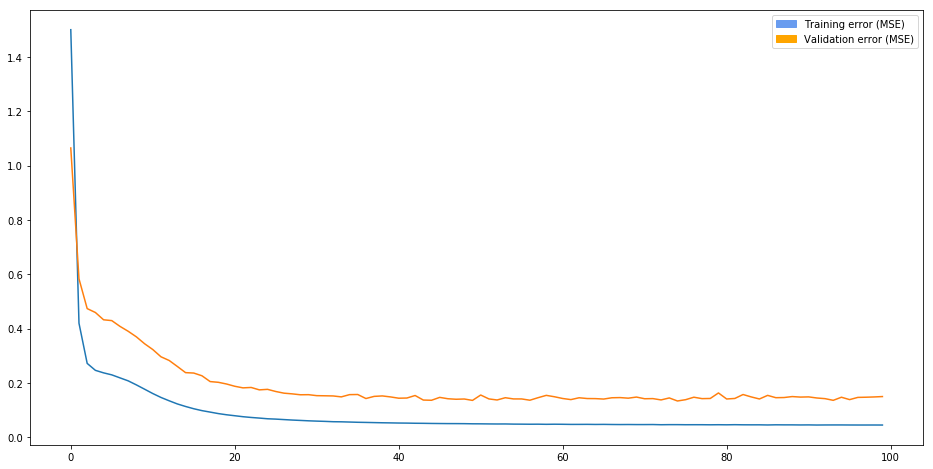

In [26]:
fig1 = plt.figure(figsize=(16, 8))
ax2 = fig1.add_subplot(111)
ax2.plot(info['train'])
ax2.plot(info['validation'])
blue_patch = mpatches.Patch(color='#699cef', label='Training error (MSE)')
orange_patch = mpatches.Patch(color='orange', label='Validation error (MSE)')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

### Prediction for last month (December 2012)

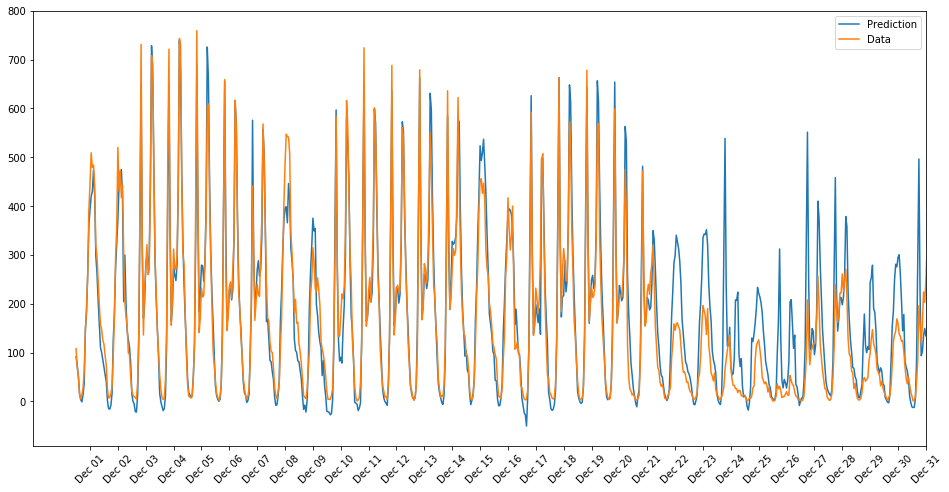

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))

mean, std = normalization_info['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides_data.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

##### Comment: 

Unable to predict correctly last 10 days of December. It's caused by the time it's peroid of Christmas and NN is unable to predict holidays correctly as there is not enough data about those peroids.